# Comparison Study

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
from data.frecency import sample, frecency_points
from data.frecency import sample_suggestions_normal as sample_suggestions

In [5]:
from optimizers import GradientDescent, AdaptiveGradientDescent, DecayedGradientDescent, RProp, Adam

In [6]:
from utils import ModelCheckpoint

## Pointwise ranking

The task in this study is pointwise ranking. Each item will be given a score by the model, which will be used for ranking all items. Since the score is a real number, the model that is used in this study is a regression function. Hinge loss, or also known as SVM loss, is used in the model optimization.

In [7]:
def svm_loss(preds, ys, delta=0):
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

In [8]:
class SVMRanking:
    def __init__(self, delta):
        self.delta = delta
        
    def fit(self, data_generator, optimizer, num_iterations=10, constraints=[], callbacks=[]):
        X, y = data_generator(2)
        num_features = X[0].shape[1]
        self.W = frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100
        self.loss = []
        
        for j in range(num_iterations):
            X, y = data_generator(4000)
            
            preds = self.predict(X)
            gradient = np.zeros(num_features)

            for xi, pi, yi in zip(X, preds, y):
                correct = yi.argmax()
                score_correct = pi[correct]

                for i, predicted_score in enumerate(pi):
                    gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            gradient /= len(X)
            
            loss = np.mean([svm_loss(pi, yi) for pi, yi in zip(self.predict(X), y)])
            accuracy = rank_accuracy(y, model.predict(X))
            
            print("[%d/%d] training: %.5f loss, %.3f accuracy" % (j + 1, num_iterations, loss, accuracy))
            
            for callback in callbacks:
                callback(self)
            
            self.W += optimizer(gradient)
            self.loss.append(loss)
            
            for constraint in constraints:
                self.W = constraint(self.W)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

Two or more items can have the same score. However, there is only one correct answer. The correct answer should be the one that is used to evaluate the model.

In [9]:
def rank_accuracy(y, preds):
    correct = 0.
    
    for yi, pi in zip(y, preds):
        if yi[pi.argmax()] == yi.max():
            correct += 1
            
    return correct / len(y)

In this case study, the model parameter should be non-negative.

In [10]:
class FrecencyConstraints:
    def __call__(self, gradient):
        return gradient - min(0, gradient.min())

## Training in single server setting

Training a machine learning model can be performed in a single machine with high computational resource. It can be done by store all the data in one single place and then use the data to train the model.

In [11]:
np.random.seed(0)
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=GradientDescent(30.),
          num_iterations=48,
          constraints=[FrecencyConstraints()],
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions)])

[1/48] training: 3.80225 loss, 0.787 accuracy
[ModelCheckpoint] New best model with 0.79670 validation accuracy
[2/48] training: 1.60038 loss, 0.944 accuracy
[ModelCheckpoint] New best model with 0.94620 validation accuracy
[3/48] training: 0.77972 loss, 0.963 accuracy
[ModelCheckpoint] New best model with 0.96370 validation accuracy
[4/48] training: 0.63540 loss, 0.964 accuracy
[ModelCheckpoint] New best model with 0.96460 validation accuracy
[5/48] training: 0.35693 loss, 0.968 accuracy
validation: 0.963 accuracy
[6/48] training: 0.56707 loss, 0.967 accuracy
validation: 0.963 accuracy
[7/48] training: 0.39944 loss, 0.965 accuracy
[ModelCheckpoint] New best model with 0.96570 validation accuracy
[8/48] training: 0.33584 loss, 0.961 accuracy
[ModelCheckpoint] New best model with 0.96870 validation accuracy
[9/48] training: 0.40017 loss, 0.963 accuracy
validation: 0.965 accuracy
[10/48] training: 0.25135 loss, 0.967 accuracy
validation: 0.966 accuracy
[11/48] training: 0.14411 loss, 0.9

In [12]:
serverGD = model.loss

After training, the learned model parameters can be compared with the true model parameters. Note that the model is evaluated by ranking the score of the items, not merely comparing the prediction and true score of the items.

In [13]:
ais = np.argsort(frecency_points)
zip(frecency_points[ais], model.W[ais])

[(12.0, 0.5433364435759508),
 (14.0, 8.960230542150786),
 (20.0, 0.0),
 (36.0, 44.143611676215514),
 (42.0, 44.26611215786202),
 (60.0, 44.251088298246984),
 (60.0, 44.14356711929147),
 (70.0, 95.40041275067807),
 (84.0, 95.40041275067648),
 (98.0, 106.93412445398285),
 (100.0, 106.93412442389078),
 (120.0, 124.57658116682717),
 (140.0, 161.82421533629864),
 (140.0, 161.82421533629864),
 (200.0, 272.4958278078269)]

## Training in federated learning setting

In several situations, sometimes the server is not allowed to keep the data. To tackle this issue, training a machine learning model can be performed using federated learning setting. In this setting, the data still can be kept in the clients while the training process is performed.

In [14]:
import random

In [15]:
class Server:
    def __init__(self, clients):
        self.clients = clients
        
        num_features = len(frecency_points)
        self.W = np.int32(frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100)
    
    def fit(self, optimizer, num_iterations, num_clients_per_iteration, constraints=[], callbacks=[]):
        
        self.loss = []
        for j in range(num_iterations):
            clients = random.sample(self.clients, num_clients_per_iteration)
            updates, losses = zip(*[client.request_update(self) for client in clients])
            
            gradient = np.mean(updates, axis=0)
            loss = np.mean(losses, axis=0)
            
            print("[%d/%d] training loss across clients %.5f" % (j + 1, num_iterations, loss))
            
            for callback in callbacks:
                callback(self)
            
            self.W += np.int32(optimizer(gradient))
            self.loss.append(loss)
            
            for constraint in constraints:
                self.W = constraint(self.W)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

In [16]:
class AnalyticalClient:
    def __init__(self, data_generator, delta=0):
        self.data_generator = data_generator
        self.delta = 0
    
    def request_update(self, model):
        X, y = self.data_generator()
        preds = model.predict(X)
        
        num_features = X[0].shape[1]
        gradient = np.zeros(num_features)
        loss = 0

        for xi, pi, yi in zip(X, preds, y):
            correct = yi.argmax()
            score_correct = pi[correct]

            for i, predicted_score in enumerate(pi):
                gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            loss += svm_loss(pi, yi)
                
        gradient /= len(X)
        loss /= len(X)
        
        return gradient, loss

In this experiment, 5000 clients are used to train the model.

In [17]:
clients = [AnalyticalClient(lambda: sample_suggestions(np.int32(np.random.exponential(.8)) + 2)) for _ in range(5000)]

In [18]:
np.random.seed(10)
server = Server(clients)
server.fit(optimizer=GradientDescent(30.),
          num_iterations=48,
           num_clients_per_iteration=400,
           constraints=[FrecencyConstraints()],
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 5000)])

[1/48] training loss across clients 12.50804
[ModelCheckpoint] New best model with 0.75240 validation accuracy
[2/48] training loss across clients 54.66287
validation: 0.591 accuracy
[3/48] training loss across clients 89.68266
[ModelCheckpoint] New best model with 0.82900 validation accuracy
[4/48] training loss across clients 6.24904
[ModelCheckpoint] New best model with 0.97820 validation accuracy
[5/48] training loss across clients 5.24104
validation: 0.975 accuracy
[6/48] training loss across clients 2.98337
[ModelCheckpoint] New best model with 0.97940 validation accuracy
[7/48] training loss across clients 1.87258
validation: 0.979 accuracy
[8/48] training loss across clients 1.57953
[ModelCheckpoint] New best model with 0.98100 validation accuracy
[9/48] training loss across clients 4.44021
validation: 0.979 accuracy
[10/48] training loss across clients 3.73792
validation: 0.979 accuracy
[11/48] training loss across clients 1.19375
[ModelCheckpoint] New best model with 0.98160 

In [19]:
federatedGD = server.loss

In [20]:
zip(frecency_points[ais], server.W[ais])

[(12.0, 0),
 (14.0, 151),
 (20.0, 149),
 (36.0, 144),
 (42.0, 564),
 (60.0, 561),
 (60.0, 567),
 (70.0, 775),
 (84.0, 826),
 (98.0, 856),
 (100.0, 855),
 (120.0, 967),
 (140.0, 1018),
 (140.0, 1018),
 (200.0, 1123)]

## Training in federated learning setting using RProp

RProp, or resilient backpropagation, is a learning method that ignores the magnitude of the gradient and only uses the sign of the gradient. The main motivation of RProp is to avoid experimenting different learning rates to train the model. In addition, it can also be used to reduce the size of the data that is sent from clients to the server. 

In [21]:
np.random.seed(10)
opt = opt = RProp(2., len(frecency_points), min_value=1, max_value=3, alpha=2., beta=0.6)
server = Server(clients)
server.fit(optimizer=opt,
          num_iterations=48,
           num_clients_per_iteration=400,
           constraints=[FrecencyConstraints()],
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 5000)])

[1/48] training loss across clients 12.50804
[ModelCheckpoint] New best model with 0.75240 validation accuracy
[2/48] training loss across clients 13.21671
[ModelCheckpoint] New best model with 0.75560 validation accuracy
[3/48] training loss across clients 10.19690
[ModelCheckpoint] New best model with 0.75900 validation accuracy
[4/48] training loss across clients 8.77127
[ModelCheckpoint] New best model with 0.79860 validation accuracy
[5/48] training loss across clients 8.40608
validation: 0.797 accuracy
[6/48] training loss across clients 6.13325
[ModelCheckpoint] New best model with 0.80240 validation accuracy
[7/48] training loss across clients 5.91335
validation: 0.799 accuracy
[8/48] training loss across clients 5.21768
[ModelCheckpoint] New best model with 0.86460 validation accuracy
[9/48] training loss across clients 4.51546
[ModelCheckpoint] New best model with 0.87060 validation accuracy
[10/48] training loss across clients 4.57298
validation: 0.869 accuracy
[11/48] train

In [22]:
federatedRProp = server.loss

In [23]:
zip(frecency_points[ais], server.W[ais])

[(12.0, 0),
 (14.0, 22),
 (20.0, 24),
 (36.0, 26),
 (42.0, 37),
 (60.0, 98),
 (60.0, 98),
 (70.0, 104),
 (84.0, 105),
 (98.0, 107),
 (100.0, 109),
 (120.0, 140),
 (140.0, 142),
 (140.0, 142),
 (200.0, 203)]

For comparison, we also try RProp in single server setting.

In [24]:
np.random.seed(0)
opt = opt = RProp(2., len(frecency_points), min_value=1, max_value=3, alpha=2., beta=0.6)
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=opt,
          num_iterations=48,
          constraints=[FrecencyConstraints()],
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions)])

[1/48] training: 3.80225 loss, 0.787 accuracy
[ModelCheckpoint] New best model with 0.79670 validation accuracy
[2/48] training: 3.50662 loss, 0.802 accuracy
[ModelCheckpoint] New best model with 0.80270 validation accuracy
[3/48] training: 2.56823 loss, 0.892 accuracy
[ModelCheckpoint] New best model with 0.89950 validation accuracy
[4/48] training: 2.05177 loss, 0.918 accuracy
[ModelCheckpoint] New best model with 0.91950 validation accuracy
[5/48] training: 1.37913 loss, 0.919 accuracy
validation: 0.914 accuracy
[6/48] training: 1.35307 loss, 0.912 accuracy
validation: 0.918 accuracy
[7/48] training: 0.98318 loss, 0.976 accuracy
[ModelCheckpoint] New best model with 0.97690 validation accuracy
[8/48] training: 1.08884 loss, 0.973 accuracy
[ModelCheckpoint] New best model with 0.97770 validation accuracy
[9/48] training: 0.96941 loss, 0.978 accuracy
validation: 0.976 accuracy
[10/48] training: 0.82543 loss, 0.978 accuracy
validation: 0.976 accuracy
[11/48] training: 0.73172 loss, 0.9

In [25]:
serverRProp = model.loss

In [26]:
zip(frecency_points[ais], model.W[ais])

[(12.0, 0.8841395490909747),
 (14.0, 1.964414843229335),
 (20.0, 0.0),
 (36.0, 2.5443888997861563),
 (42.0, 2.3030498667128256),
 (60.0, 3.0718100137430895),
 (60.0, 3.1435671192914683),
 (70.0, 108.81441964384018),
 (84.0, 111.79769150093125),
 (98.0, 111.73605317801935),
 (100.0, 113.88456966395219),
 (120.0, 114.57658116682717),
 (140.0, 114.3305922286066),
 (140.0, 114.82421533629864),
 (200.0, 287.4958278078268)]

## Performance comparison

Learning in different settings can affect the convergence rate of the training process. The higher the convergence rate, the fewer number of iterations are needed to achieve the target. In this study, we are interested in comparing the convergence rate of different settings.

In [27]:
loss = pd.DataFrame({
    'Server_GD': serverGD,
    'Server_RProp': serverRProp,
    'Federated_GD': federatedGD,
    'Federated_RProp': federatedRProp})

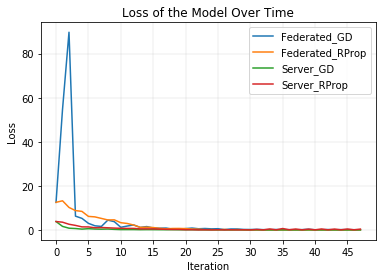

In [28]:
loss.plot.line()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Loss of the Model Over Time')
plt.xticks(np.arange(0, 50, step=5))
plt.grid(True, linewidth=0.2);